<a href="https://colab.research.google.com/github/lucasdemouraa/LLMENADEBRACIS2025/blob/main/plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from io import StringIO
import math
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
def consolidate_datasets(dataset_list, model_name_list):
    frames = []
    for dataset, model_name in zip(dataset_list, model_name_list):
        # Create headerless DataFrame from dataset
        df = pd.read_csv(StringIO(dataset), header=None)
        # Insert the model name as the third column (after question number and answer key)
        df.insert(2, "model", model_name)
        frames.append(df)

    # Concatenate all DataFrames.
    consolidated_df = pd.concat(frames, ignore_index=True)

    # Rename columns:
    # First column: question number, second: answer key, third: model name, remaining 10 columns: answers.
    column_names = ["question", "key", "model"] + [f"answer_{i+1}" for i in range(10)]
    consolidated_df.columns = column_names

    return consolidated_df


def compute_abs_accuracy_metric(row, N):
    """Return 1 if the Nth answer for the question is correct. Otherwise, return 0."""

    return 1 if row[f"answer_{N}"] == row["key"] else 0


def count_correct_answers(row, N=10):
    """
    Count the number of correct answers in the first n attempts.
    """
    correct = 0
    for i in range(1, N + 1):
        if row[f"answer_{i}"] == row["key"]:
            correct += 1
    return correct


def compute_mean_accuracy_metric(row, N):
    """Compute the mean accuracy over the first N answers for the question."""
    score = 0
    for i in range(1, N + 1):
        if row[f"answer_{i}"] == row["key"]:
            score += 1
    return score / N


def compute_pass_metric(row, N):
    """Return 1 if at least one of the first N answers is correct, else 0."""
    for i in range(1, N + 1):
        if row[f"answer_{i}"] == row["key"]:
            return 1
    return 0


def compute_tar_metric(row, N):
    """
    Return 1 if all the first N answers are the same (regardless if correct), else 0.
    """
    answers = [row[f"answer_{i}"] for i in range(1, N + 1)]
    return int(len(set(answers)) == 1)


def compute_cons_metric(row, N):
    """
    Return 1 if there is a unique consensus (most frequent) answer among the first N attempts
    and that unique mode equals the key, else 0.
    """
    # Get the first N answers.
    answers = [row[f"answer_{i}"] for i in range(1, N + 1)]
    counter = Counter(answers)
    max_count = max(counter.values())
    # Check for a unique mode: there must be exactly one answer with frequency equal to max_count.
    modes = [ans for ans, count in counter.items() if count == max_count]
    if len(modes) != 1:
        return 0
    consensus_ans = modes[0]
    return 1 if consensus_ans == row["key"] else 0

def add_metrics(df):
    """
    Add 'abs_accuracy_N', 'mean_accuracy_N', 'median_accuracy_N',, 'entropy_N', 'pass_N', 'cons_N' and 'TAR_N' columns to the DataFrame.
    """
    for N in range(1, 11):
        # Add abs_accuracy column.
        df[f"abs_accuracy_{N}"] = df.apply(
            lambda row: compute_abs_accuracy_metric(row, N), axis=1
        )
        # Add mean_accuracy column.
        df[f"mean_accuracy_{N}"] = df.apply(
            lambda row: compute_mean_accuracy_metric(row, N), axis=1
        )
        # Add pass column.
        df[f"pass_{N}"] = df.apply(lambda row: compute_pass_metric(row, N), axis=1)
        # Add cons column.
        df[f"cons_{N}"] = df.apply(lambda row: compute_cons_metric(row, N), axis=1)
        # Add TAR_N column.
        df[f"tar_{N}"] = df.apply(lambda row: compute_tar_metric(row, N), axis=1)

    return df


def compute_accuracy_per_run(row, num_answers=10):
    acc_per_run = []
    for i in range(1, num_answers + 1):
        acc_per_run.append(int(row[f"answer_{i}"] == row["key"]))
    return acc_per_run


def compute_all_metrics(df, max_N=10):
    results = []
    models = df["model"].unique()

    for model in models:
        df_model = df[df["model"] == model]
        row_result = {"model": model}

        # Precompute accuracies per question
        all_accuracies = []
        for _, row in df_model.iterrows():
            all_accuracies.append(
                compute_accuracy_per_run(row, max_N)
            )  # always get full 10
        all_accuracies = np.array(all_accuracies)  # shape: (num_questions, max_N)

        for N in range(1, max_N + 1):
            # pass@N
            pass_N = df_model.apply(
                lambda row: compute_pass_metric(row, N), axis=1
            ).mean()

            # TAR@N
            tar_N = df_model.apply(
                lambda row: compute_tar_metric(row, N), axis=1
            ).mean()

            # cons@N
            cons_N = df_model.apply(
                lambda row: compute_cons_metric(row, N), axis=1
            ).mean()

            # Accuracy metrics for the first N runs
            run_accuracies = all_accuracies[:, :N].mean(
                axis=0
            )  # mean accuracy per "run"
            min_acc_N = run_accuracies.min()
            median_acc_N = np.median(run_accuracies)
            mean_acc_N = np.mean(run_accuracies)
            max_acc_N = run_accuracies.max()
            spread_N = max_acc_N - min_acc_N

            # Add all results for this N
            row_result[f"pass_{N}"] = pass_N
            row_result[f"tar_{N}"] = tar_N
            row_result[f"cons_{N}"] = cons_N
            row_result[f"min_accuracy_{N}"] = min_acc_N
            row_result[f"mean_accuracy_{N}"] = mean_acc_N
            row_result[f"max_accuracy_{N}"] = max_acc_N
            row_result[f"accuracy_spread_{N}"] = spread_N

        results.append(row_result)

    return pd.DataFrame(results)

def map_names(name_list, name_map):
    """Map given names to more readable names based on given map."""
    mapped_names = []
    for name in name_list:
        if name in name_map:
            mapped_names.append(name_map[name])
        else:
            mapped_names.append(name)
    return mapped_names

    # Visualize metric distribution over N attempts as line plot across models.
def visualize_metric_distribution_line(
    df,
    metric,
    metric_name,
    title=None,
    file=None,
    y_max=1.0,
    figsize=(5.5, 3.5),
    bbox_to_anchor=None,
    model_name_map={},
    model_order=None,
):
    if model_order is not None:
        models = model_order
    else:
        models = df["model"].unique()

    Ns = list(range(1, 11))
    # Define a list of distinct markers.
    markers = ["o", "s", "D", "^", "v", "P", "X", "*", "h", "8"]
    line_styles = ["-", "--", "-.", ":"]

    # Line plot for metric.
    fig, ax = plt.subplots(figsize=figsize)
    for i, model in enumerate(models):
        df_model = df[df["model"] == model]
        mapped_name = map_names([model], model_name_map)[0]
        metric_vals = [df_model[f"{metric}_{N}"].mean() for N in Ns]
        ax.plot(
            Ns,
            metric_vals,
            marker=markers[i % len(markers)],
            linestyle=line_styles[i % len(line_styles)],
            label=mapped_name,
            clip_on=False,
        )
    ax.set_xlabel("Number of Responses (N)")
    ax.set_xticks(Ns)
    ax.set_xlim(1, 10)
    ax.set_ylabel(metric_name)
    ax.set_ylim(0, y_max)
    # Get the number of legend items to set ncol dynamically
    handles, labels = ax.get_legend_handles_labels()
    # plt.legend(bbox_to_anchor=(1.05, 0.5), loc="center left", title="Model")
    ax.legend(
        bbox_to_anchor=bbox_to_anchor,
        loc="center left",
        title="Model",
        # ncol=num_items,
        # frameon=False,
    )
    plt.margins(x=0.8)
    if title:
        plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    if file:
        plt.savefig(file, bbox_inches="tight")
    plt.show()

# Visualize metrics distribution over N attempts as line plot across models.
def visualize_metrics_distribution_line(
    df,
    metric_list,
    dataset_type="all",
    title_suffix="over N Responses",
    y_max=1.0,
    figsize=(5.5, 3.5),
    bbox_to_anchor=(0.5, -0.05),
    metric_name_map={},
    model_order=None,
):
    for metric in metric_list:
        visualize_metric_distribution_line(
            df,
            metric,
            metric_name_map[metric],
            model_order=model_order,
            # title=f"{metric_name_map[metric]} {title_suffix}",
            file=f"lineplot_{metric}_{dataset_type}.pdf",
            y_max=y_max,
            figsize=figsize,
            bbox_to_anchor=bbox_to_anchor,
        )

# Visualize metric heatmap per question for all models.
def visualize_metric_heatmap_per_question(
    df,
    metric,
    y_label,
    title=None,
    file=None,
    highlight_questions=None,
    model_order=None,
    model_name_map={},
    figsize=(8, 1.6)
    ):
    # Pivot the DataFrame to have models as rows and questions as columns.
    pivot = df.pivot(index="model", columns="question", values=metric)
    # If a model_order is provided, reorder the rows accordingly.
    if model_order is not None:
        pivot = pivot.reindex(model_order)
    plt.figure(figsize=figsize)
    plt.imshow(pivot, aspect="auto", cmap="Blues")
    plt.colorbar(label=y_label, pad=0.03)
    plt.xlabel("Question")
    plt.ylabel("Model")
    if title:
        plt.title(title)
    # Create custom x tick labels: if the column value is numeric and a single digit, pad with a zero.
    custom_labels = []
    for q in pivot.columns:
        try:
            q_int = int(q)
            # If it's a single-digit number (0-9), format as "0X"
            custom_labels.append(f"{q_int:02d}")
        except ValueError:
            # If conversion fails, just use the original string value.
            custom_labels.append(str(q))
    plt.xticks(range(len(pivot.columns)), custom_labels, rotation=0, fontsize=9)
    # plt.xticks(range(len(pivot.columns)), pivot.columns, rotation=90)
    # Set y ticks.
    plt.yticks(range(len(pivot.index)), map_names(pivot.index, model_name_map))

    ax = plt.gca()

    # Add grid lines to the heatmap.
    num_rows, num_cols = pivot.shape

    # Add horizontal grid lines
    for y in range(num_rows):
        ax.axhline(y - 0.5, color="gray", linewidth=1.1)

    # Add vertical grid lines
    for x in range(num_cols):
        ax.axvline(x - 0.5, color="gray", linewidth=1.1)

    # Highlight the tick labels of the provided questions in red.
    if highlight_questions:
        # Convert tick labels to string (or numeric) and change color if that value is in highlight_questions.
        for label in ax.get_xticklabels():
            try:
                # Try converting tick label text to a numeric value.
                q_val = float(label.get_text())
            except ValueError:
                q_val = label.get_text()  # leave it as string if conversion fails.
            if q_val in highlight_questions or str(q_val) in [
                str(q) for q in highlight_questions
            ]:
                label.set_color("red")

        # Add red rectangle around heat cells for the listed questions.
        col_list = list(pivot.columns)
        for q in highlight_questions:
            if q in col_list:
                x_index = col_list.index(q)
                # Create a rectangle that covers the column for this question.
                rect = plt.Rectangle(
                    (x_index - 0.5, -0.5),
                    1,
                    len(pivot.index),
                    linewidth=2,
                    edgecolor="red",
                    facecolor="none",
                    clip_on=False,
                    zorder=10,
                )
                ax.add_patch(rect)

    plt.tight_layout()
    if file:
        plt.savefig(file, bbox_inches="tight")
    plt.show()

# Visualize metric heatmaps per question for all models.
def visualize_metrics_heatmaps_per_question(
    df, metric_list, dataset_type="all", title_suffix="per Question", highlighted_questions=None, model_order=[], metric_name_map={}, model_name_map={},
    figsize=(8, 1.6)
):
    for metric in metric_list:
        visualize_metric_heatmap_per_question(
            df,
            f"{metric}_10",
            metric_name_map[metric],
            # title=f"{metric_name_map[metric]} {title_suffix}",
            file=f"heatmap_{metric}_{dataset_type}.pdf",
            highlight_questions=highlighted_questions,
            model_order=model_order,
            model_name_map=model_name_map,
            figsize=figsize,
        )

In [3]:
# Map model names to more readable names.
model_name_map = {
    "4o": "GPT-4o",
    "o1": "o1",
    "gemini_flash_2": "Gemini 2.0",
    "deepseek_r1": "DeepSeek-R1",
}

# Map metric names to more readable names.
metric_name_map = {
    "abs_accuracy": "Absolute Accuracy",
    "abs_accuracy_10": "Absolute Accuracy",
    "mean_accuracy": "Mean Accuracy",
    "mean_accuracy_10": "Mean Accuracy",
    "accuracy_spread": "Accuracy Spread",
    "accuracy_spread_10": "Accuracy Spread",
    "median_accuracy": "Median Accuracy",
    "median_accuracy_10": "Median Accuracy",
    "entropy": "Mean Entropy",
    "entropy_10": "Mean Entropy",
    "pass": "pass@N",
    "pass_10": "pass@N",
    "cons": "cons@N",
    "cons_10": "cons@N",
    "tar": "TAR@N",
    "tar_10": "TAR@N",
}

# List of questions excluded from the ENADE BCS score
excluded_questions = [12, 13, 17, 21, 25, 32]

# Create data sets
model_4o_data = """
9,E,E,D,D,D,D,D,D,D,D,D
10,B,B,B,B,B,B,B,B,B,B,B
11,D,E,D,A,E,A,E,D,E,E,E
12,B,C,E,D,D,D,E,D,E,E,E
13,E,D,D,D,D,D,D,D,D,D,D
14,C,C,B,B,B,B,C,C,C,C,C
15,C,C,C,C,C,C,C,C,C,C,C
16,B,D,C,A,E,A,E,C,C,E,E
17,C,A,A,C,A,A,C,C,C,C,A
18,E,E,E,E,C,E,E,E,E,E,E
19,D,E,X,E,E,E,E,E,E,E,E
20,A,A,A,D,A,B,A,C,C,C,C
21,E,C,C,C,C,C,C,C,C,C,C
22,A,A,A,A,A,A,A,A,A,A,A
23,C,E,X,E,X,E,X,E,E,E,E
24,E,A,E,A,D,A,E,A,A,C,A
25,B,E,E,E,E,E,E,E,E,E,E
26,A,A,E,E,E,E,E,E,E,E,E
27,D,C,D,B,D,B,D,D,D,D,D
28,B,E,E,E,E,E,E,E,E,E,E
30,E,E,E,E,E,A,E,E,E,E,E
31,E,E,B,E,B,E,E,E,E,E,E
32,A,D,D,D,D,D,D,D,D,D,A
34,C,D,C,C,E,D,E,C,C,C,C
35,D,D,D,D,X,D,D,D,E,E,E
"""

model_o1_data = """
9,E,X,X,X,X,X,X,X,X,X,E
10,B,B,B,B,B,B,B,B,B,B,B
11,D,X,D,D,D,D,D,D,D,D,D
12,B,B,B,B,B,B,B,B,B,B,B
13,E,D,D,D,D,D,D,D,D,D,D
14,C,C,C,C,C,C,C,C,C,C,C
15,C,C,C,C,C,C,C,C,C,C,C
16,B,C,C,X,C,C,X,C,E,E,C
17,C,C,C,C,C,C,C,C,C,C,C
18,E,E,X,A,X,X,E,E,E,X,E
19,D,D,D,D,D,D,D,D,D,D,D
20,A,A,A,A,A,A,A,A,A,A,A
21,E,C,C,C,D,C,C,C,D,C,C
22,A,A,A,A,A,A,A,A,A,A,A
23,C,C,C,C,X,C,C,C,C,C,C
24,E,A,E,E,E,D,E,E,E,E,E
25,B,E,B,E,B,E,E,E,E,B,E
26,A,E,E,A,A,A,A,A,A,A,E
27,D,D,D,D,D,D,D,D,D,D,D
28,B,E,B,B,B,B,B,B,B,B,B
30,E,E,E,E,E,E,E,E,E,E,E
31,E,E,E,E,E,E,E,E,E,E,E
32,A,X,A,A,A,A,X,A,A,A,A
34,C,C,C,C,C,C,C,C,C,C,C
35,D,D,D,D,D,D,D,D,D,D,D
"""

model_gemini_flash_2_data = """
9,E,E,E,E,E,E,E,E,E,E,E
10,B,B,B,B,B,B,B,B,B,B,B
11,D,D,D,D,D,D,D,D,D,D,D
12,B,B,B,B,B,B,B,B,B,B,B
13,E,D,D,D,D,D,D,D,D,D,D
14,C,C,C,B,C,C,C,C,C,B,C
15,C,C,C,C,C,C,C,C,C,C,C
16,B,A,A,A,A,A,A,A,A,A,A
17,C,C,C,C,C,C,C,C,C,C,C
18,E,E,E,E,E,E,E,E,E,E,E
19,D,D,D,D,D,D,D,D,D,D,D
20,A,A,A,A,A,A,A,A,A,A,A
21,E,E,E,E,D,E,D,E,E,E,E
22,A,A,A,A,A,A,A,A,A,A,A
23,C,C,C,C,C,C,C,C,C,C,C
24,E,E,E,E,E,E,E,E,E,E,E
25,B,B,B,B,B,B,B,B,B,B,B
26,A,C,E,E,E,A,E,A,E,E,E
27,D,E,A,D,D,A,D,D,A,A,D
28,B,B,B,B,A,B,A,E,B,B,B
30,E,E,E,E,E,E,E,E,E,A,E
31,E,D,B,A,B,B,E,D,E,E,B
32,A,A,A,A,A,A,A,A,A,A,A
34,C,E,D,C,E,A,C,C,E,C,C
35,D,D,D,D,D,D,D,D,D,D,D
"""

model_deepseek_r1_data = """
9,E,D,D,D,D,D,X,D,D,D,D
10,B,B,B,B,B,B,B,B,B,B,B
11,D,D,D,D,D,D,D,D,D,D,D
12,B,B,B,B,B,B,B,B,B,B,B
13,E,D,D,D,D,D,D,D,D,D,D
14,C,C,C,C,C,C,C,C,C,C,C
15,C,C,C,C,C,C,C,C,C,C,C
16,B,A,C,D,C,C,D,C,C,D,C
17,C,D,B,C,B,B,C,B,B,B,B
18,E,E,E,E,E,E,E,E,E,E,E
19,D,D,D,D,D,D,D,D,D,D,D
20,A,A,A,A,A,A,A,A,A,A,A
21,E,D,D,D,D,D,D,D,D,D,D
22,A,A,A,A,A,A,A,A,A,A,A
23,C,C,C,C,C,C,C,C,C,C,C
24,E,D,D,E,E,B,C,A,E,C,B
25,B,D,X,X,D,D,D,D,D,D,D
26,A,A,A,A,A,A,A,A,A,A,A
27,D,X,X,X,A,A,X,X,X,X,D
28,B,B,B,B,B,B,B,B,B,B,B
30,E,E,E,E,E,E,E,E,E,E,E
31,E,X,X,X,X,X,X,X,X,X,X
32,A,D,D,X,B,B,D,D,D,D,D
34,C,C,E,C,C,C,C,X,C,C,C
35,D,D,D,D,D,D,D,D,D,D,D
"""

dataset_list = [
    model_4o_data,
    model_o1_data,
    model_gemini_flash_2_data,
    model_deepseek_r1_data,
]

# Create consolidated DataFrame
df_all = consolidate_datasets(dataset_list, model_name_map.keys())

# Add metrics to the DataFrame
df_all = add_metrics(df_all)

# Compute all metrics
df_all_metrics = compute_all_metrics(df_all, max_N=10)

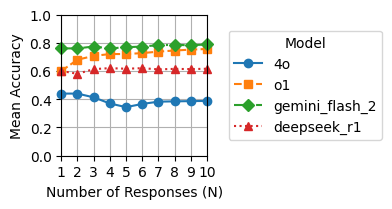

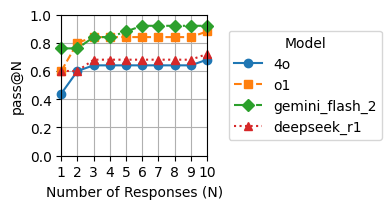

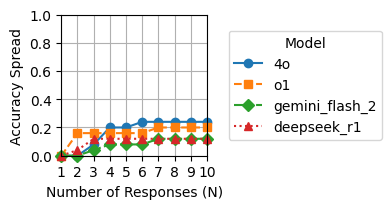

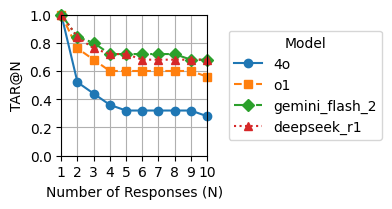

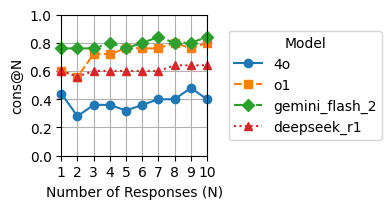

In [4]:
# Visualize metrics distribution over N attempts as line plot across models.
metric_list = [
    "mean_accuracy",
    "pass",
    "accuracy_spread",
    "tar",
    "cons"
]
visualize_metrics_distribution_line(
    df_all_metrics,
    metric_list,
    dataset_type="all",
    figsize=(4.2, 2.2),
    bbox_to_anchor=(1.10, 0.5),
    # y_max=0.3,
    model_order=["4o", "o1", "gemini_flash_2", "deepseek_r1"],
    metric_name_map=metric_name_map,
)

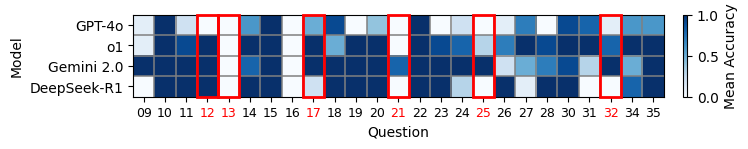

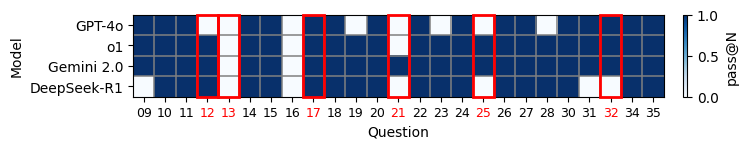

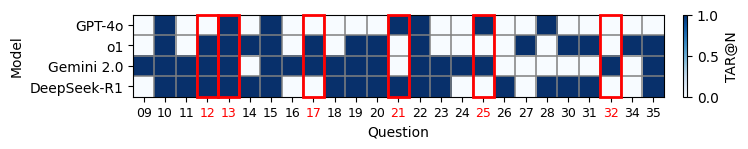

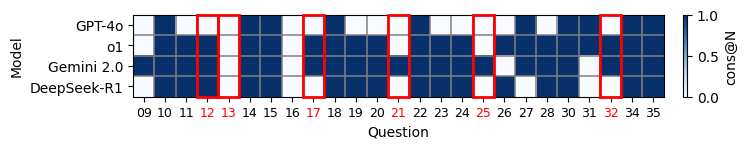

In [5]:
# Visualize metric heatmaps per question for all models.
metric_list = [
    "mean_accuracy",
    "pass",
    "tar",
    "cons"
]
visualize_metrics_heatmaps_per_question(
    df_all,
    metric_list,
    metric_name_map=metric_name_map,
    model_name_map=model_name_map,
    dataset_type="all",
    highlighted_questions=excluded_questions,
    model_order=["4o", "o1", "gemini_flash_2", "deepseek_r1"],
    figsize=(8, 1.6),
)